# 08. Milestone Project 2: PyTorch Paper Replicating
เป้าหมายของการทำซ้ำงานวิจัยด้านการเรียนรู้ของเครื่อง (Machine Learning Research Paper Replicating) คือการเปลี่ยนงานวิจัยในรูปแบบของกระดาษวิจัยให้กลายเป็นโค้ดที่ใช้งานได้

ในโน้ตบุ๊กนี้ เราจะทำการทำซ้ำสถาปัตยกรรม **Vision Transformer (ViT)** ตามงานวิจัยโดยใช้ **PyTorch** ซึ่งสามารถดูรายละเอียดได้ที่ลิงก์นี้: [https://arxiv.org/abs/2010.11929](https://arxiv.org/abs/2010.11929)

ดูตัวอย่างโน้ตบุ๊กที่เป็นโค้ดจริงได้ที่นี่: [https://www.learnpytorch.io/08_pytorch_paper_replicating/](https://www.learnpytorch.io/08_pytorch_paper_replicating/)

## 0. Getting setup
เช่นเดียวกับที่เราเคยทำมาก่อนหน้านี้ เรามาทำให้แน่ใจว่าเรามีโมดูลทั้งหมดที่จำเป็นสำหรับส่วนนี้แล้ว

เราจะทำการ import ไฟล์ Python script (เช่น `data_setup.py` และ `engine.py`) ที่เราได้สร้างขึ้นในส่วน **05. PyTorch Going Modular**

เพื่อทำเช่นนี้ เราจะดาวน์โหลดโฟลเดอร์ `going_modular` จาก repository **pytorch-deep-learning** (ถ้าเรายังไม่มี)

นอกจากนี้เราจะติดตั้งแพ็กเกจ **torchinfo** หากยังไม่ได้ติดตั้ง

`torchinfo` จะช่วยให้เราได้เห็นภาพแสดงแบบจำลองของเราต่อไปในภายหลัง

และเนื่องจากเราจะใช้แพ็กเกจ **torchvision v0.13** (ซึ่งมีให้ใช้งานตั้งแต่เดือนกรกฎาคม 2022) เราจะตรวจสอบให้แน่ใจว่าเรามีเวอร์ชันล่าสุด

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1.Get data
เป้าหมายหลักของสิ่งที่เราพยายามทำคือการทำซ้ำสถาปัตยกรรม **Vision Transformer (ViT)** เพื่อใช้แก้ปัญหา **FoodVision Mini** ของเรา

เพื่อที่จะทำเช่นนั้น เราจำเป็นต้องมีข้อมูล

ซึ่งก็คือรูปภาพของ **pizza**, **steak**, และ **sushi** ที่เราเคยใช้มาก่อนหน้านี้

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#2.Create Datasets and DataLoaders

**DataLoader** สรุปง่ายๆ บ! ก็คือเป็นเครื่องมือที่ใช้ในการ **เตรียมข้อมูล** ให้เหมาะสมสำหรับการฝึกโมเดลใน **PyTorch** โดยจัดการข้อมูลเป็นชุดๆ (batch), สุ่มลำดับข้อมูล, และทำการ preprocessing ข้อมูลให้พร้อมสำหรับการทำนายหรือฝึกโมเดล

สรุปหน้าที่หลักของ DataLoader:
- โหลดข้อมูลเป็น batch
- สุ่มลำดับข้อมูล (shuffle)
- ประมวลผลข้อมูลล่วงหน้า (preprocessing)
- ทำงานแบบขนานเพื่อเพิ่มความเร็วในการโหลดข้อมูล

ทั้งหมดนี้ช่วยให้กระบวนการฝึกโมเดลเป็นไปอย่างราบรื่นและมีประสิทธิภาพมากขึ้น

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:

# Create a batch size of 32 (gthe paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## 2.3 Visualize a single a image
As always, let's adhere to the motto, visualize, visualize, visualize!

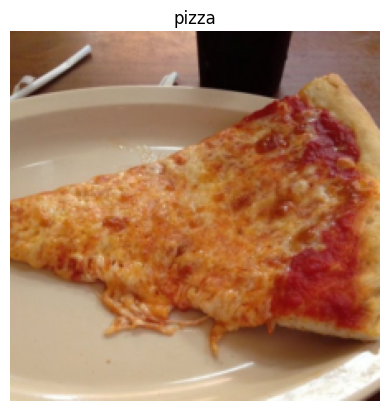

torch.Size([3, 224, 224])


In [ ]:
# prompt: Visualize a single a image

import matplotlib.pyplot as plt

# Get a single image from a batch
image, label = next(iter(train_dataloader))
image = image[0] # get a single image from the batch
label = label[0] # get a single label from the batch

# Display the image
plt.imshow(image.permute(1, 2, 0)) # adjust dimensions for matplotlib color|Hight|width
plt.title(class_names[label])
plt.axis(False)
plt.show()
print(image.shape)

#3.Replicating ViT: Overview
การอ่านงานวิจัยด้านการเรียนรู้ของเครื่อง (Machine Learning) ทั้งฉบับอาจดูน่ากลัว

ดังนั้นเพื่อให้เข้าใจได้ง่ายขึ้น เราสามารถแบ่งออกเป็นส่วนย่อย ๆ ดังนี้:

- อินพุต (Inputs) - อะไรที่ถูกใส่เข้าไปในโมเดล? (ในกรณีของเรา คือเทนเซอร์ของภาพ)
- เอาต์พุต (Outputs) - อะไรที่ออกมาจากโมเดลหรือจากเลเยอร์/บล็อก? (ในกรณีของเรา เราต้องการให้โมเดลส่งออกป้ายการจำแนกประเภทของภาพ)
- เลเยอร์ (Layers) - รับอินพุตแล้วประมวลผลด้วยฟังก์ชันหนึ่ง (เช่น Self-Attention)
- บล็อก (Blocks) - การรวบรวมของเลเยอร์หลาย ๆ ชั้น
- โมเดล (หรือสถาปัตยกรรม) - การรวบรวมของบล็อกหลาย ๆ บล็อก

##3.1ViT overview: pieces of the puzzle
- รูปที่ 1: ภาพรวมของสถาปัตยกรรม
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>
- สมการ 4 สมการ: สมการทางคณิตศาสตร์ที่กำหนดฟังก์ชันของแต่ละเลเยอร์/บล็อก
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

- คำอธิบายข้อความ (หัวข้อที่ 3.1)

#### Section 3.1 อธิบายสมการต่างๆ:

**สมการ 1:**
บทความนี้อธิบายเกี่ยวกับการใช้งานโมเดล Transformer ในการประมวลผลภาพ 2 มิติ แทนที่จะใช้ข้อมูลอินพุตเป็นลำดับ 1 มิติของการฝังโทเค็นแบบดั้งเดิม (token embeddings) เหมือนในการประมวลผลข้อความ โมเดลนี้ปรับภาพ $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ (ที่ $H$ และ $W$ คือความละเอียดของภาพ และ $C$ คือจำนวนช่องสัญญาณ) เป็นลำดับของ "แพตช์" (patches) หรือส่วนย่อยๆ ของภาพ 2 มิติ ซึ่งถูกแบนและย่อให้เป็น 1 มิติ $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$ โดยที่ $N = H W / P^{2}$ แทนจำนวนแพตช์ทั้งหมด และถือเป็นความยาวของลำดับอินพุตที่มีประสิทธิภาพสำหรับ Transformer  

การฝังตำแหน่ง (Position embeddings) แบบ 1 มิติถูกเพิ่มเข้าไปในแพตช์เพื่อรักษาข้อมูลตำแหน่ง โดยการฝังนี้สามารถเรียนรู้ได้เอง โดยไม่จำเป็นต้องใช้การฝังตำแหน่ง 2 มิติที่ซับซ้อนกว่า ซึ่งผลลัพธ์จากการฝังนี้จะเป็นอินพุตให้กับ encoder ของ Transformer

**สมการ 1:**
โดยปกติแล้ว Transformer จะรับข้อมูลอินพุตเป็นลำดับ 1 มิติ (เช่น ข้อความ) แต่เมื่อใช้กับภาพซึ่งเป็นข้อมูล 2 มิติ ระบบจะทำการแบ่งภาพ $\mathbf{x}$ ที่มีขนาด $H \times W \times C$ (โดยที่ $H$ และ $W$ คือความละเอียดของภาพ และ $C$ คือจำนวนช่องสัญญาณสี) ออกเป็นส่วนย่อยๆ ที่เรียกว่า "แพตช์" โดยแพตช์เหล่านี้ถูกจัดให้อยู่ในรูปแบบลำดับ 1 มิติ $\mathbf{x}_{p}$ ซึ่งมีจำนวนแพตช์รวมเป็น $N$ ทำให้สามารถนำลำดับนี้ไปใช้กับ Transformer ได้

นอกจากนี้ การฝังตำแหน่ง (Position embeddings) แบบ 1 มิติถูกเพิ่มเข้าไปในแพตช์แต่ละแพตช์เพื่อรักษาข้อมูลตำแหน่งของส่วนต่างๆ ของภาพ ซึ่งช่วยให้โมเดลเข้าใจโครงสร้างภาพได้ดีขึ้น โดยการฝังตำแหน่งนี้สามารถเรียนรู้ได้เอง และผลลัพธ์จากการฝังนี้จะกลายเป็นข้อมูลอินพุตให้กับส่วน encoder ของ Transformer

**สรุป :**
* สรุปคือการแยกรูปภาพเป็นส่วนๆและติดหมายเลขไว้ เพื่อเวลาที่นำภาพมาประกอบกันใหม่รูปภาพจะไม่ผิดแปลกไปจากเดิม

* การประมวลผลภาพด้วย Vision Transformer คือการแบ่งภาพออกเป็นส่วนย่อย ๆ (หรือแพตช์) พร้อมทั้งฝังข้อมูลตำแหน่งให้กับแต่ละแพตช์ไว้ เพื่อให้เมื่อทำการประมวลผลข้อมูลทั้งหมดแล้ว โมเดลสามารถเรียงลำดับและจัดการส่วนต่าง ๆ ได้ถูกต้องตามโครงสร้างเดิมของภาพ ซึ่งช่วยคงความถูกต้องของภาพเดิมไว้แม้หลังผ่านการประมวลผล

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


---

**สมการ 2&3:**
Encoder ของ Transformer (Vaswani et al., 2017) ประกอบด้วยการสลับกันระหว่างเลเยอร์ของ Multi-Headed Self-Attention (MSA) และบล็อก MLP โดยในแต่ละบล็อกจะมีการใช้งาน Layer Normalization (LN) ก่อนการคำนวณ และเชื่อมต่อด้วยการเพิ่มค่า residual หลังจากทุกบล็อก (Wang et al., 2019; Baevski & Auli, 2019)

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

คล้ายกับโทเค็น [class] ของ BERT, เราเพิ่มการฝังข้อมูลที่สามารถเรียนรู้ได้เข้าไปในลำดับของแพตช์ที่ฝังข้อมูล ($\mathbf{z}_{0}^{0} = \mathbf{x}_{\text{class}}$) โดยสถานะของโทเค็นนี้ที่ผลลัพธ์ของ Transformer encoder ($\mathbf{z}_{L}^{0}$) จะทำหน้าที่เป็นตัวแทนของภาพ (image representation) ซึ่งเรียกว่า $y$ สำหรับการทำการจำแนก ในช่วง pre-training และ fine-tuning จะมีการเชื่อมต่อ classification head เข้ากับ $\mathbf{z}_{L}^{0}$ โดย classification head นี้จะถูกสร้างด้วย MLP ที่มีเลเยอร์ซ่อนหนึ่งเลเยอร์ในขั้นตอน pre-training และด้วยเลเยอร์เชิงเส้นเดียวในขั้นตอน fine-tuning

- **MLP (Multilayer Perceptron)**: โครงข่ายประสาทเทียมที่ประกอบด้วยหลายเลเยอร์ ใช้สำหรับประมวลผลข้อมูล
- **ในขั้นตอน pre-training**: MLP จะมีหนึ่งเลเยอร์ซ่อน (hidden layer) เพื่อให้สามารถเรียนรู้โครงสร้างข้อมูลที่ซับซ้อนมากขึ้น
- **ในขั้นตอน fine-tuning**: MLP จะลดเหลือเพียงเลเยอร์เชิงเส้นเดียว (single linear layer) ซึ่งทำให้การปรับจูนสำหรับงานเฉพาะเจาะจงรวดเร็วและมีประสิทธิภาพ

##3.2ตารางที่ 1: ค่าพารามิเตอร์ต่าง ๆ สำหรับสถาปัตยกรรม/การฝึกโมเดล
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

  * ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
  * ViT-B/16 = ViT-Base with image patch size 16x16
  * Layers - the number of transformer encoder layers
  * Hidden size $D$ - the embedding size throughout the architecture
  * MLP size - the number of hidden units/neurons in the MLP
  * Heads - the number of multi-head self-attention

1. **ViT-Base, ViT-Large, และ ViT-Huge** คือขนาดที่แตกต่างกันของสถาปัตยกรรมโมเดล **Vision Transformer (ViT)**:
   - ทั้งสามเวอร์ชันใช้สถาปัตยกรรมเดียวกัน แต่ขนาดของโมเดลต่างกันในแง่ของจำนวน **Layers**, ขนาดของ **Hidden size**, และจำนวนของ **Multi-head Attention heads** เป็นต้น
   - ขนาดของโมเดลที่ใหญ่ขึ้นมักจะช่วยให้โมเดลมีความสามารถในการเรียนรู้และประมวลผลข้อมูลที่ซับซ้อนมากขึ้น แต่ก็ใช้ทรัพยากรมากขึ้นด้วย

2. **ViT-B/16**:
   - หมายถึง **ViT-Base** ซึ่งมีขนาด **image patch size** เท่ากับ 16x16 พิกเซล
   - ViT มักจะแบ่งภาพออกเป็นชิ้นเล็ก ๆ (patch) และขนาดของ patch ที่เล็กลงจะทำให้ได้จำนวนข้อมูลย่อยที่มากขึ้น

3. **Layers**:
   - คือจำนวนชั้นของ **Transformer Encoder** ในโมเดล โดยแต่ละ Layer ประกอบด้วยกลไก **Self-Attention** และ **Feedforward neural network (MLP)**
   - โมเดลที่มีชั้นมากขึ้นจะสามารถจับความสัมพันธ์ในข้อมูลได้ดีขึ้น แต่จะซับซ้อนและใช้พลังงานในการประมวลผลมากขึ้น

4. **Hidden size ($D$)**:
   - เป็นขนาดของเวกเตอร์ที่ใช้ในขั้นตอนการ **Embedding** หรือการแปลงชิ้นส่วนของภาพให้เป็นเวกเตอร์ที่มีขนาดคงที่
   - ขนาดนี้ถูกใช้อย่างสม่ำเสมอตลอดโมเดล หากขนาด $D$ ใหญ่ขึ้น โมเดลจะสามารถเก็บข้อมูลได้มากขึ้น

5. **MLP size**:
   - หมายถึงจำนวนหน่วยประมวลผล (neurons) ในส่วนของ **Multi-Layer Perceptron (MLP)** ที่อยู่หลังการประมวลผลด้วย **Self-Attention**
   - MLP ขนาดใหญ่ขึ้นหมายความว่ามีความสามารถในการประมวลผลข้อมูลที่ซับซ้อนมากขึ้น

6. **Heads**:
   - คือจำนวน **Multi-head Attention heads** ในแต่ละชั้นของ **Transformer**
   - Multi-head Attention ช่วยให้โมเดลสามารถโฟกัสไปที่หลายจุดของข้อมูลพร้อม ๆ กัน ทำให้การเรียนรู้ความสัมพันธ์ระหว่างชิ้นส่วนของภาพดียิ่งขึ้น
   - การเพิ่มจำนวน heads หมายถึงการเพิ่มจำนวนมุมมองที่โมเดลสามารถพิจารณาข้อมูลได้

แผนภาพของ **Vision Transformer (ViT)** ซึ่งเป็นโมเดลที่ใช้สำหรับการวิเคราะห์ภาพโดยอาศัยหลักการของ **Transformer** แบบที่ใช้ในงานด้านประมวลผลภาษาธรรมชาติ (NLP) แต่ปรับให้ใช้กับข้อมูลรูปภาพแทน
ขอสรุปสั้น ๆ เกี่ยวกับขั้นตอนของ Vision Transformer (ViT):

1. **การแบ่งภาพเป็นชิ้นส่วนย่อย (Patches)**:
   - ภาพถูกแบ่งออกเป็นชิ้นเล็ก ๆ ขนาดคงที่ (fixed-size patches) คล้ายกับการแบ่งภาพออกเป็นตารางย่อย ๆ เพื่อให้แต่ละชิ้นถูกใช้เป็นข้อมูลแทนภาพทั้งหมด

2. **การฝังข้อมูล (Embedding)**:
   - แต่ละชิ้นส่วนของภาพจะถูกแปลงเป็นเวกเตอร์ (vector) ซึ่งเรียกว่า **Linear Projection** โดยรวมกับข้อมูลเกี่ยวกับตำแหน่ง (Position Embedding) ของชิ้นส่วนในภาพ
   - ข้อมูลเวกเตอร์เหล่านี้จะถูกป้อนเข้าสู่ **Transformer Encoder**

3. **การใช้ Transformer Encoder**:
   - ข้อมูลจากแต่ละชิ้นของภาพจะถูกประมวลผลผ่าน **Multi-Head Attention** (ให้โมเดลรู้ว่าความสัมพันธ์ระหว่างชิ้นส่วนไหนมีความสำคัญ) และผ่านกระบวนการ Normalization (การปรับข้อมูลให้อยู่ในรูปแบบที่เข้าใจง่ายขึ้นสำหรับโมเดล)
   - ข้อมูลเหล่านี้จะถูกส่งผ่าน Layer ต่าง ๆ หลายครั้งเพื่อให้โมเดลสามารถเรียนรู้ข้อมูลที่ซับซ้อนได้

4. **การทำ Classification**:
   - สำหรับการทำงานจำแนกประเภท (เช่น บอกว่าในภาพนี้คืออะไร: รถ, นก, ลูกบอล ฯลฯ) โมเดลจะเพิ่ม **classification token** เข้าไปเพื่อช่วยในการบอกผลลัพธ์ และผลลัพธ์สุดท้ายจะถูกส่งไปยัง **MLP Head** ซึ่งจะทำการจำแนกประเภทของภาพ

ViT ใช้แนวคิดหลัก ๆ จาก **Transformer** ของ Vaswani et al. (2017) ที่มีชื่อเสียงในงานด้าน NLP มาใช้กับการประมวลผลภาพ โดยเปลี่ยนจากคำ (word) ในประโยค เป็นชิ้นส่วนของภาพ



#4.Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???



### 4.1 Calculate input and output shapes by hand

**สมการ 1:**
ภาพรวมซองโมเดล: บทความนี้นำเสนอภาพรวมของโมเดล Transformer ซึ่งจะแสดงในรูปภาพที่ 1 โดย Transformer มาตรฐานจะได้รับข้อมูลเข้าเป็นสำดับ 1 มิติของการฝังข้อมูล (token embeddings) ชึ่งเป็นการ แปลงข้อมูลที่ใช้ในภาษา

การจัดการกับภาพ 2 มิติ: เพื่อรองรับการทำงานกับภาพ 2 มิติ (2D images) โมเดลจะต้องทำการแปลงภาพ $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ ชึ่งประกอบด้วย:
- $H$ : ความสูงของภาพ
- $W$ : ความกว้างของภาพ
- $C$ : จำนวนช่องสัญญาณ (channels)

การแปลงจะทำให้ภาพถูกจัดระเบียบใหม่เป็นลำดับของแพตช์ 2 มิติที่แบน $\mathrm{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$ ซึ่ง:
- $P$ : ขนาดของแต่ละแพตช์ $(\mathrm{P}, \mathrm{P})$
- $N=\frac{H \times W}{P^2}$ : จำนวนแพตช์ที่ได้จากการแบ่งภาพ ซึ่งเป็นความยาวของลำดับข้อมูลเข้า (input sequence length) ที่มีผลต่อ Transformer

ขนาดของเวกเตอร์แฝง: Transformer จะใช้ขนาดเวกเตอร์แฝง (latent vector size) ที่คงที่ $D$ ในทุกเลเยอร์ การแปลงแพตช์จะทำให้เวกเตอร์เหล่านี้ถูกแปลงเป็น $D$ มิติด้วยการใช้การโปรเจกชันเชิงเส้นที่สามารถฝึกฝนได้ (trainable linear projection)

การเรียกผลดัพธ์: ผลลัพธ์ของการโปรเจกชันนี้จะถูกเรียกว่า "patch embeddings" ซึ่งใช้เป็นข้อมูลเข้าในการ ประมวลผลเพิ่มเติมในโมเดล Transformer.

### สรุปโดยรวม
โมเดล Transformer ถูกออกแบบมาให้สามารถจัดการกับข้อมูลภาพ 2 มิติได้ โดยการแปลงภาพให้เป็นลำดับของแพตช์แบน ซึ่งจะช่วยให้การประมวลผลเป็นไปอย่างมีประสิทธิภาพและสามารถเรียนรู้จากข้อมูลที่มีโครงสร้างได้ดียิ่งขึ้น.

> **สมการ 1:**
การฝังตำแหน่ง (Position embeddings) ถูกเพิ่มเข้าไปในแพตช์ที่ฝังข้อมูลไว้เพื่อรักษาข้อมูลตำแหน่งของแต่ละแพตช์ในภาพ เราใช้การฝังตำแหน่งแบบ 1 มิติที่สามารถเรียนรู้ได้ เนื่องจากไม่พบว่าการใช้การฝังตำแหน่งแบบ 2 มิติที่ซับซ้อนกว่าจะช่วยเพิ่มประสิทธิภาพอย่างมีนัยสำคัญ ลำดับของเวกเตอร์ฝังข้อมูลที่ได้จะถูกส่งเป็นอินพุตเข้าสู่ encoder ของ Transformer

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches


196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


##4.2 Turning a single image into patchse
Let's visualize

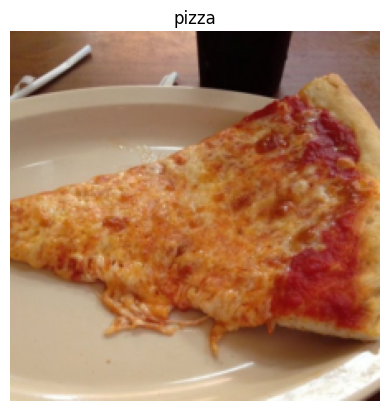

In [ ]:
#view a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [ ]:
image.shape

torch.Size([3, 224, 224])

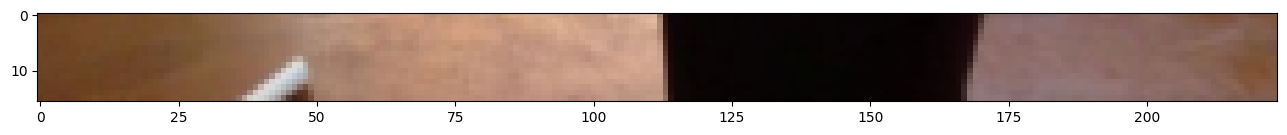

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

#index to plot the top row pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])


Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


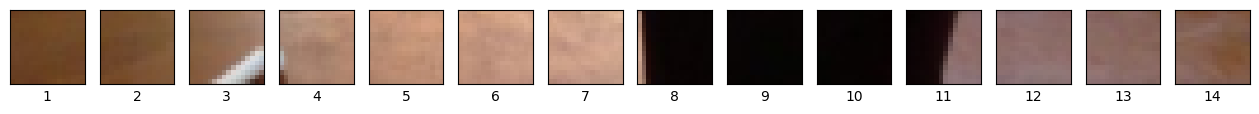

In [ ]:
#setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = int(img_size / patch_size)
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))
# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])



Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist

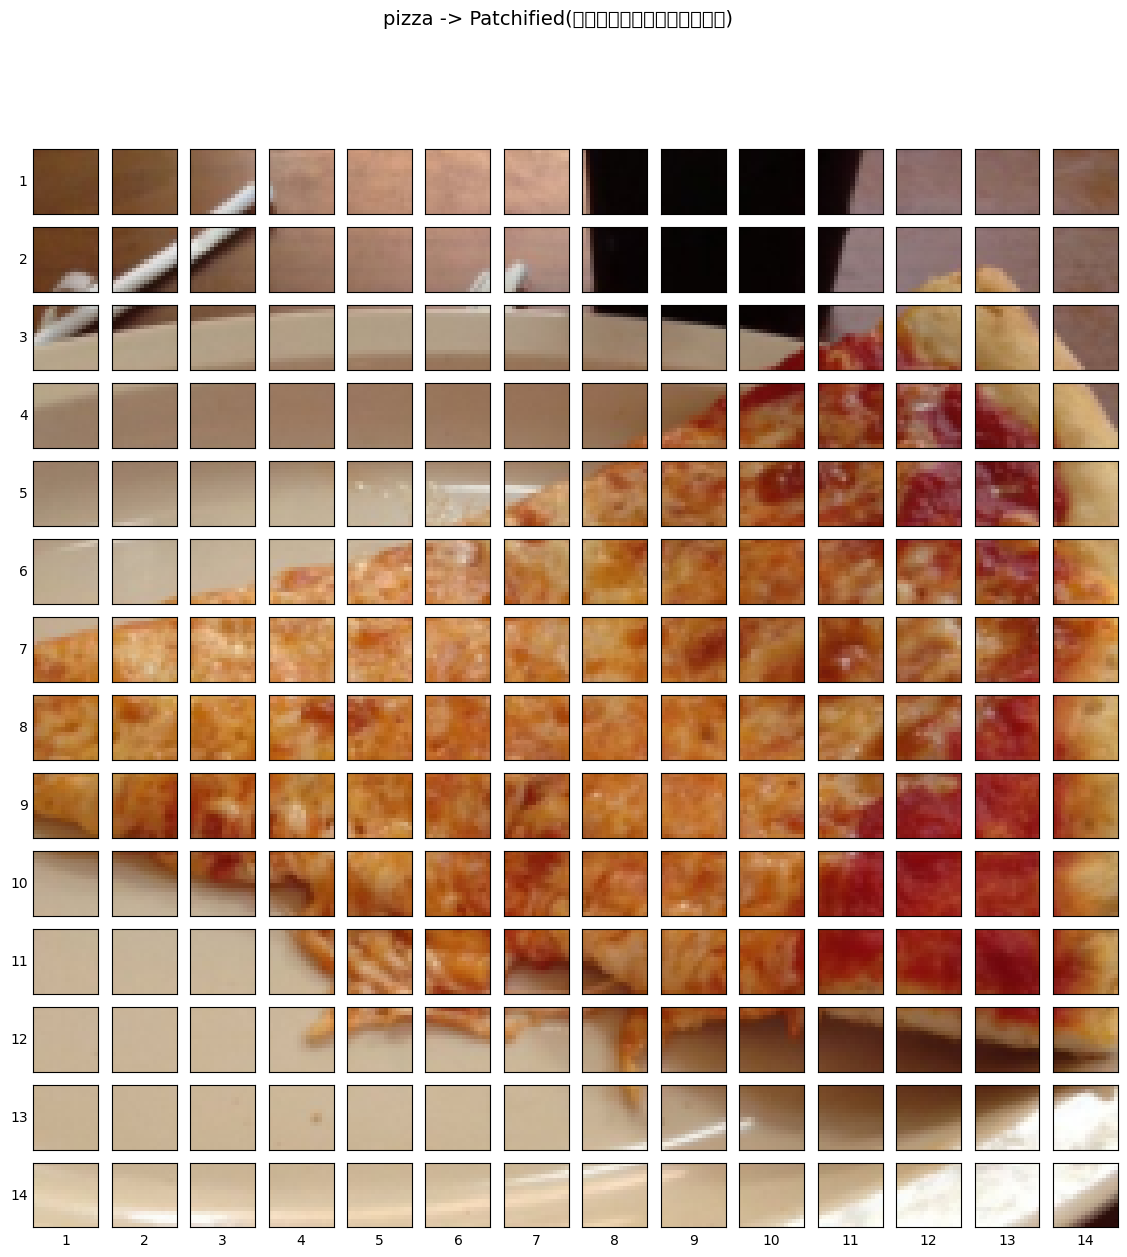

In [ ]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size ทำารหารลงตัวไม่มีเศษ"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height / วนซ้ำตามแนวความสูง
                                    patch_width:patch_width+patch_size, # iterate through width / วนซ้ำตามแนวความกว้าง
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified(แบ่งเป็นแพตช์)", fontsize=14)
plt.show()

##4.3Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

บางทีเราอาจสร้างแพตช์ของภาพและการฝังตัว(embeddings)ของแพตช์ภาพในขั้นตอนเดียวได้ โดยใช้ torch.nn.Conv2d() และตั้งค่าพารามิเตอร์ kernel_size และ stride ให้เท่ากับ patch_size

In [ ]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
#สร้างเลเยอร์ conv2d เพื่อแปลงภาพให้เป็นแพตช์ของแผนที่คุณลักษณะที่สามารถเรียนรู้ได้ embeddings
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1 for ViT-Base หัวข้อ 3.2
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

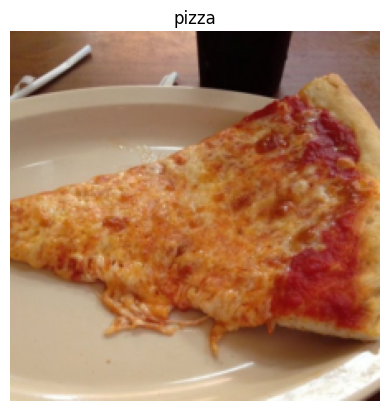

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
image_out_of_conv.requires_grad

True

Now we've passed a single image to our conv2d layer, it's shape is:
```py
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

`torch.Size([1, 768, 14, 14])` คือเทนเซอร์ที่มี 4 มิติ โดยรายละเอียดแต่ละมิติคือ:

1. **1**: จำนวนของตัวอย่างในชุดข้อมูล (batch size)
2. **768**: จำนวนช่อง (channels) หรือคุณลักษณะที่เรียนรู้ได้ในแต่ละพิกเซล
3. **14**: ความสูงของภาพ (height) หรือจำนวนแถวของพิกเซล
4. **14**: ความกว้างของภาพ (width) หรือจำนวนคอลัมน์ของพิกเซล

ดังนั้น เทนเซอร์นี้คือภาพที่มีขนาด 14x14 พิกเซล และมี 768 ช่อง (เช่น คุณลักษณะจาก Conv2D หรือ feature maps) และมีจำนวน batch เท่ากับ 1

Showing random convolutional feature maps from indexes: [229, 264, 57, 208, 334]


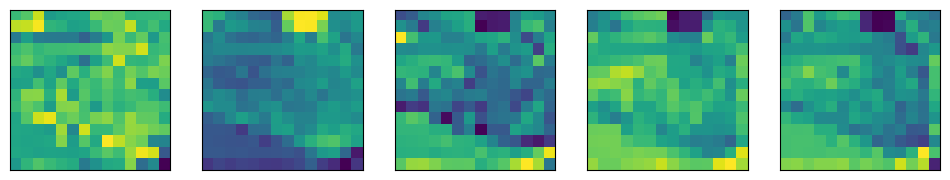

In [ ]:
#นี้คือการแสดงรูปภาพในลักษนะ Convolutional Layer มองเห็น
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # ลบค่าแสดงผลที่ไม่จำเป็น (labels และ ticks) จากแกน X และ Y เพื่อให้กราฟดูสะอาดขึ้น


In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad


(tensor([[[ 0.0310,  0.0721,  0.1287,  0.1494,  0.1497,  0.1534,  0.1761,
           -0.0094,  0.0246,  0.0267,  0.1490,  0.1656,  0.1365,  0.1102],
          [ 0.0725,  0.0789,  0.0369,  0.1310,  0.1488,  0.1674,  0.1621,
           -0.0678,  0.0248,  0.0295,  0.3387,  0.1512,  0.1637,  0.1258],
          [ 0.1719,  0.1735,  0.1815,  0.1262,  0.0866,  0.1065,  0.0804,
            0.1186,  0.1318,  0.0092,  0.2291,  0.1251,  0.0873,  0.0923],
          [ 0.1333,  0.1238,  0.1244,  0.1174,  0.1131,  0.1117,  0.1038,
            0.0609,  0.0815,  0.0124,  0.0449,  0.1709,  0.0765,  0.0827],
          [ 0.1459,  0.1532,  0.1648,  0.1584,  0.1593,  0.1582,  0.1367,
           -0.0078, -0.0146, -0.0117,  0.0385,  0.0342,  0.0992,  0.1745],
          [ 0.1797,  0.1738,  0.1265,  0.2044,  0.1136,  0.1298,  0.0478,
            0.0147,  0.0514,  0.0409,  0.0173,  0.0411,  0.0962,  0.0712],
          [ 0.0652,  0.0989,  0.0678,  0.0512, -0.0155,  0.0327,  0.0067,
            0.0228,  0.0175,  0.

##4.4 Flattening the patch embedding with torch.nn.Flatten()

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

ตอนนี้เรามีชุดของแผนที่คุณลักษณะการคอนโวลูชัน (patch embeddings) ที่เราต้องการแปลงเป็นลำดับของ patch embeddings เพื่อให้ตรงกับข้อกำหนดของอินพุตของ ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
from torch import nn
# เมื่อใช้ nn.Flatten() ข้อมูลทั้งหมดจะถูก "ยุบ" หรือ "บีบอัด" ให้มาอยู่ในแถวเดียวที่มีจำนวนค่าทั้งหมดที่เคยอยู่ในหลายๆ มิติ
flatten_layer = nn.Flatten(start_dim=2,# ตือ 1 เริ่มจาก0จึงได้2
                           end_dim=3)# คือ 3 เริ่มนับจากตำแหน่ง 1, 768, 14, 14 เริ่มจาก 0 จึงได้ 3

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


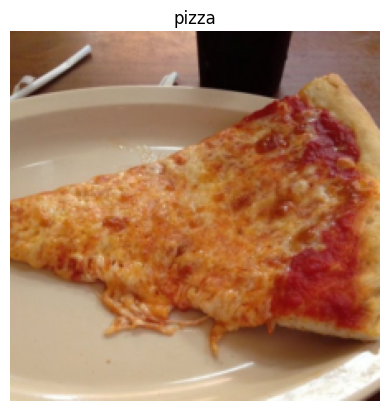

In [ ]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer จัดเรียงข้อมูลใหม่
# Flattened image feature map shape: torch.Size([1[0], 768[1], 196[2]])
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


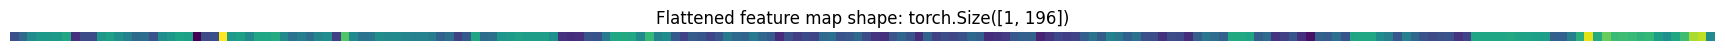

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

##4.5 Turning the ViT patch embedding layer into a PyTorch module
We want this module to do a few things:

1. Create a class called PatchEmbedding that inherits from nn.Module.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using nn.Conv2d().
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a foward() that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

1. สร้างคลาสชื่อ PatchEmbedding ที่สืบทอดจาก nn.Module
2. กำหนดค่าเริ่มต้นด้วยไฮเปอร์พารามิเตอร์ที่เหมาะสม เช่น จำนวนช่องสัญญาณ มิติการฝัง และขนาดของแพตช์
3. สร้างเลเยอร์เพื่อแปลงภาพให้เป็นแพตช์ที่ฝังโดยใช้ nn.Conv2d()
4. สร้างเลเยอร์เพื่อทำการแบนแผนที่ฟีเจอร์ของผลลัพธ์จากเลเยอร์ในข้อ 3
5. กำหนดฟังก์ชัน forward() เพื่อกำหนดการคำนวณไปข้างหน้า (เช่น ผ่านเลเยอร์จากข้อ 3 และ 4)
6. ตรวจสอบให้แน่ใจว่ารูปร่างของผลลัพธ์สะท้อนรูปร่างที่ต้องการของการฝังแพตช์

In [ ]:
#1.Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  #2.Initialize with appropriate hyperparameters
  def __init__(self, in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): #from Table 1 vit-base
     super().__init__()
     self.patch_size = patch_size
     #3.Create a layer to turn an image into embedded patches
     self.patcher = nn.Conv2d(in_channels=in_channels,
                        out_channels=embedding_dim,
                        kernel_size=patch_size,
                        stride=patch_size,
                        padding=0)
     #4.Create a layer to flatten the feature maps
     self.flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
  #Perform thr forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten_layer(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

เรียกใช้ PatchEmbedding





In [ ]:
set_seeds()
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image  = patchify(image.unsqueeze(0))
patch_embedded_image .shape
print(f"Output patch embedding sequence shape: {patch_embedded_image .shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

##4.6 Creating the class token embedding
Want to: prepend a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.3685,  0.0471, -0.0509,  ...,  0.2020, -0.1836,  0.1284],
         [-0.3981,  0.0634, -0.0736,  ...,  0.2430, -0.2039,  0.1219],
         [-0.4524,  0.2668, -0.2278,  ...,  0.4735, -0.2775,  0.1160],
         ...,
         [-1.0487,  0.3048, -0.3302,  ...,  0.6920, -0.3196,  0.3446],
         [-0.9759,  0.2860, -0.2764,  ...,  0.7626, -0.4498,  0.3493],
         [-0.7004,  0.1129,  0.0419,  ...,  0.4046, -0.4719,  0.3464]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1] #ลบมิติออกไปเลย
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),#batch_size, number_of_patches, embedding_dimension
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape


torch.Size([1, 196, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3685,  0.0471, -0.0509,  ...,  0.2020, -0.1836,  0.1284],
         [-0.3981,  0.0634, -0.0736,  ...,  0.2430, -0.2039,  0.1219],
         ...,
         [-1.0487,  0.3048, -0.3302,  ...,  0.6920, -0.3196,  0.3446],
         [-0.9759,  0.2860, -0.2764,  ...,  0.7626, -0.4498,  0.3493],
         [-0.7004,  0.1129,  0.0419,  ...,  0.4046, -0.4719,  0.3464]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


##4.7 Creating the position embedding
Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

ต้องการสร้างชุดตำแหน่งฝังตัวแบบ 1 มิติที่สามารถเรียนรู้ได้ แล้วเพิ่มเข้าไปในลำดับของการฝังตัวของแพตช์

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)
# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
# ดูลำดับของการฝังตัวของแพตช์ที่มีการฝังตัวของคลาสเพิ่มไว้ข้างหน้า
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3685,  0.0471, -0.0509,  ...,  0.2020, -0.1836,  0.1284],
          [-0.3981,  0.0634, -0.0736,  ...,  0.2430, -0.2039,  0.1219],
          ...,
          [-1.0487,  0.3048, -0.3302,  ...,  0.6920, -0.3196,  0.3446],
          [-0.9759,  0.2860, -0.2764,  ...,  0.7626, -0.4498,  0.3493],
          [-0.7004,  0.1129,  0.0419,  ...,  0.4046, -0.4719,  0.3464]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.6315,  1.0471,  0.9491,  ...,  1.2020,  0.8164,  1.1284],
         [ 0.6019,  1.0634,  0.9264,  ...,  1.2430,  0.7961,  1.1219],
         ...,
         [-0.0487,  1.3048,  0.6698,  ...,  1.6920,  0.6804,  1.3446],
         [ 0.0241,  1.2860,  0.7236,  ...,  1.7626,  0.5502,  1.3493],
         [ 0.2996,  1.1129,  1.0419,  ...,  1.4046,  0.5281,  1.3464]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


1. ขั้นแรกคือ การแบ่งภาพเป็นชิ้นๆต่อแถวกันเป้นแนวนอน
2. คลาสโทเคนก้คือกำหนดว่า ในภาพที่ตัดแบ่งเป็นชิ้นๆนี้คือ เช่น ภาพนี้คือภาพแมวที่ตัดเป็นชิ้นๆ
3. คือการแปลงภาพให้พร้อมนำไปใช้โดย นำขั้นตอนที่ 1 และ 2 มาประกอบรวมกัน โดยตัดแบ่งภาพและคลุมด้วยคลาสและแปลงให้นำไปใช้ต่อไปได้

##4.8 Putting it all together: from image to embedding
We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all in one cell.

การแบ่งข้อมูลออกเป็นแพตช์และสร้างคลาส ตําแหน่ง และการฝังแพตช์
1. Setting the patch size (we'll use as it's widely used throughout the paper and for ViT-Base).16
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our layer.`PatchEmbedding`
4. Creating a layer (the one we made in section 4.5) with a and (from Table 1 for ViT-Base).`PatchEmbeddingpatch_size=16` `embedding_dim=768`
5. Passing the single image through the layer in 4 to create a sequence of patch embeddings.`PatchEmbedding`
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [ ]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} ")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


#5.Equation 2: Multihead Self-Attention (MSA block)
* Multihead self-attention = which part of a sequence should pay the most attention to itself?

  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$
 dimension, in our case, the $D$
 dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

5. สมการ 2: Multihead Self-Attention (MSA block)  
* Multihead self-attention = ส่วนใดของลำดับที่ควรให้ความสำคัญกับตัวเองมากที่สุด?  

  * ในกรณีนี้ เรามีชุดของภาพฝังตัวเป็นแพตช์ต่าง ๆ ซึ่งแพตช์ใดมีความสัมพันธ์กันอย่างมาก  
เราต้องการให้เครือข่ายประสาทเทียมของเรา (ViT) เรียนรู้ความสัมพันธ์นี้/การแทนค่าความสัมพันธ์นี้  
  * สามารถจำลอง MSA ใน PyTorch โดยใช้: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html  

* LayerNorm = การทำให้เป็นชั้นปกติ (LayerNorm) เป็นเทคนิคในการทำให้การกระจายค่าของชั้นกลางเป็นปกติ ช่วยให้เกิด gradient ที่ราบรื่นขึ้น การฝึกที่เร็วขึ้น และความแม่นยำในการทำให้เป็นแบบทั่วไปที่ดีขึ้น  

  * Normalization = ทำให้ทุกค่าในชุดข้อมูลมีค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานเดียวกัน  
  * ใน PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html จะทำให้ค่ามีความปกติตามมิติ \(D\) ซึ่งในกรณีนี้ มิติ \(D\) คือมิติของ embedding  
เมื่อเราทำ normalization ตามมิติของ embedding

    * มันเหมือนกับการทำให้บันไดในบันไดเลื่อนทุกขั้นมีขนาดเท่ากัน

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

`MultiHeadSelfAttentionBlock` ซึ่งใช้สำหรับการประมวลผลข้อมูลผ่าน Multi-Head Self-Attention ในโมเดลที่ใช้กับ Vision Transformer (ViT):

- `__init__` คือการตั้งค่าตัวแปรต่างๆ เช่น ขนาด embedding (`embedding_dim`), จำนวน head (`num_heads`), และ dropout (`attn_dropout`).
- ใน `forward` จะทำการ Normalize ข้อมูลก่อน แล้วนำข้อมูลที่ผ่านการ Normalize มาใช้ใน Multi-Head Attention โดยจะใช้ตัวเองเป็น query, key, และ value (Self-Attention).
  
การทำงานนี้เหมือนกับการที่หลายๆ หัวของหุ่นยนต์ช่วยกันประมวลผลข้อมูลที่ได้รับ แล้วนำมารวมกันให้เกิดผลลัพธ์ที่ดีที่สุด.

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


`MultiHead_Self_AttentionBlock` และนำข้อมูลที่เป็นภาพที่แบ่งเป็นพาทช์ (patch) และตำแหน่ง (position) ไปผ่าน MSA block:

- `multihead_self_attention_block` คือการสร้างอินสแตนซ์ของ MSA block ด้วยขนาด `embedding_dim` 768, จำนวน `num_heads` 12, และ `attn_dropout` 0.
- หลังจากนั้นจะนำข้อมูลที่เป็นการฝังพาทช์และตำแหน่ง (`patch_and_position_embedding`) ผ่าน MSA block เพื่อให้ได้ผลลัพธ์ที่เป็นเอาต์พุตจากการประมวลผล.
- การพิมพ์ `shape` ของข้อมูลที่เข้าและออกจาก MSA block เพื่อดูขนาดของข้อมูลก่อนและหลังการประมวลผล.

เหมือนกับการที่เราเอาภาพที่ถูกตัดเป็นชิ้นเล็กๆ มาให้หุ่นยนต์หลายตัวช่วยกันดูและวิเคราะห์ข้อมูล แล้วดูว่าผลลัพธ์สุดท้ายหลังการประมวลผลเป็นอย่างไร.

#6.Equation 3: Multilayer Perceptron (MLP block)
* MLP = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called torch.nn.Linear() and in TensorFlow they might be called tf.keras.layers.Dense()
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU
  * MLP number of hidden units = MLP Size in Table 1
* Dropout = Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3
In pseudocode:

MLP
```py
x = linear -> non-linear -> dropout -> linear -> dropout
```

สมการที่ 3: Multilayer Perceptron (MLP block)
* MLP = MLP ประกอบด้วยสองชั้นพร้อมกับฟังก์ชันการกระตุ้นแบบ GELU (ตามที่อธิบายในส่วน 3.1)
  * MLP = เป็นคำทั่วไปที่ใช้เรียกบล็อกที่มีหลายชั้น, ชั้นสามารถมีหลายชั้นหรือแม้แต่ชั้นเดียว
  * ชั้นใน MLP คือ: fully-connected, dense, linear, feed-forward ซึ่งมักจะใช้ชื่อเดียวกันในบางกรณี เช่น ใน PyTorch จะใช้ `torch.nn.Linear()` และใน TensorFlow ใช้ `tf.keras.layers.Dense()`
  * GELU ใน PyTorch - [เอกสารของ PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU)
  * จำนวนหน่วยซ่อนใน MLP = ขนาดของ MLP ตามที่ระบุในตารางที่ 1
* Dropout = Dropout เมื่อใช้งานจะถูกนำไปใช้หลังจากทุกชั้น dense ยกเว้น qkv-projections และหลังจากที่เพิ่มตำแหน่งให้กับ patch embeddings. โมเดลแบบไฮบริดจะถูกฝึกด้วยการตั้งค่าที่เหมือนกับ ViT
  * ค่า Dropout สามารถดูได้จากตารางที่ 3

**MLP** (Multilayer Perceptron) คือโมเดลที่ประกอบไปด้วยหลายๆ ชั้นของการประมวลผลที่ใช้ในการเรียนรู้ข้อมูล โดยทั่วไป MLP จะประกอบไปด้วย:

1. **ชั้นเชื่อมต่อ (Fully-Connected Layer)**: ข้อมูลที่ผ่านมาจะถูกเชื่อมต่อกันจากทุกๆ นิวรอนในชั้นก่อนหน้าไปยังนิวรอนในชั้นถัดไป.
2. **ฟังก์ชันการกระตุ้น (Activation Function)**: เช่น ReLU, GELU เพื่อเพิ่มความสามารถในการเรียนรู้ของโมเดล.
3. **Dropout**: ใช้เพื่อลดการ overfitting โดยการปิดการทำงานของบางนิวรอนในระหว่างการฝึก.

MLP ถูกใช้ในงานต่างๆ เช่น การจำแนกประเภท หรือการทำนายค่าต่างๆ โดยจะมีชั้นซ่อนหลายชั้นขึ้นอยู่กับความซับซ้อนของข้อมูล.

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) # same as above

! โค้ดนี้สร้างคลาส `MLPBlock` ที่ใช้สำหรับทำงานกับ **Multilayer Perceptron (MLP)** โดยมีขั้นตอนดังนี้:

1. **การสร้าง LayerNorm**: ใช้ `nn.LayerNorm()` สำหรับการปรับแต่งข้อมูลให้มีการกระจายปกติ (normalize) โดยมี `embedding_dim` เป็นขนาดของข้อมูลที่เข้ามา.
  
2. **การสร้าง MLP**: ใช้ `nn.Sequential()` เพื่อเชื่อมโยงหลายๆ ชั้นเข้าไปในลำดับเดียวกัน:
   - **Linear Layer 1**: แปลงจาก `embedding_dim` เป็น `mlp_size`.
   - **GELU**: ฟังก์ชันการกระตุ้นที่ใช้เพื่อเพิ่มความไม่เป็นเชิงเส้นในโมเดล.
   - **Dropout**: ใช้เพื่อป้องกันการ overfitting โดยการปิดบางนิวรอนในการฝึก.
   - **Linear Layer 2**: แปลงจาก `mlp_size` กลับไปเป็น `embedding_dim`.
   - **Dropout 2**: ใช้อีกครั้งเพื่อลด overfitting.

3. **ฟังก์ชัน `forward`**:
   - ข้อมูลจะถูกส่งไปผ่าน `LayerNorm` และหลังจากนั้นผ่าน MLP block.
   - มีการคอมเมนต์แสดงว่า `return self.mlp(self.layer_norm(x))` ก็สามารถใช้แทน `x = self.layer_norm(x)` แล้วผ่าน `self.mlp(x)` ได้เช่นกัน.

สรุปเหมือนกับการที่เราใช้หลายๆ ชั้นการประมวลผลในขั้นตอนต่างๆ เพื่อให้โมเดลสามารถเรียนรู้ข้อมูลที่ซับซ้อนขึ้น.

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


! โค้ดนี้ทำการสร้างอินสแตนซ์ของ `MLPBlock` และส่งผลลัพธ์จาก `MSABlock` ผ่าน `MLPBlock`:

1. **สร้างอินสแตนซ์ของ MLPBlock**:
   - ใช้ค่าพารามิเตอร์ `embedding_dim=768`, `mlp_size=3072`, และ `dropout=0.1` เพื่อตั้งค่า MLP block ที่จะใช้.
  
2. **ส่งข้อมูลผ่าน MLPBlock**:
   - ข้อมูลที่ได้จาก `MSABlock` (ในตัวแปร `patched_image_through_msa_block`) จะถูกส่งผ่าน `MLPBlock`.
  
3. **พิมพ์ขนาดข้อมูล**:
   - พิมพ์ขนาดของข้อมูลก่อนและหลังการประมวลผลใน MLP block เพื่อให้เห็นการเปลี่ยนแปลงขนาดของข้อมูล.
  
เหมือนกับการที่เรานำข้อมูลที่ผ่านการประมวลผลจาก MSA block มาทำการประมวลผลเพิ่มเติมใน MLP block ก่อนที่จะแสดงผลลัพธ์สุดท้าย.

#7.Creating the Transformer Encoder
The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

  * Encoder = turn a sequence into learnable representation
  * Decoder = go from learn representation back to some sort of sequence
  * Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)
In pseudocode:

# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```
การสร้าง Transformer Encoder
Transformer Encoder เป็นการผสมกันระหว่างบล็อกของ MSA (สมการที่ 2) และ MLP (สมการที่ 3) ที่สลับกันไปมา

และมีการเชื่อมต่อแบบ residual ระหว่างแต่ละบล็อก

- **Encoder** = เปลี่ยนลำดับข้อมูลเป็นตัวแทนที่สามารถเรียนรู้ได้
- **Decoder** = เปลี่ยนตัวแทนที่เรียนรู้กลับไปเป็นลำดับข้อมูล
- **Residual connections** = การเพิ่มข้อมูลจากชั้นก่อนหน้านี้เข้าไปยังผลลัพธ์ของชั้นถัดไป ช่วยให้สามารถสร้างเครือข่ายที่ลึกขึ้น (ป้องกันไม่ให้ค่าน้ำหนักเล็กเกินไป)
```

##7.1 Create a custom Transformer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

##7.2 Create a Transformer Encoder layer with in-built PyTorch layers
So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer
```py
7.2 การสร้างชั้น Transformer Encoder ด้วยเลเยอร์ใน PyTorch

จนถึงตอนนี้เราได้สร้าง Transformer Encoder ด้วยมือเอง

แต่เนื่องจากสถาปัตยกรรม Transformer ได้รับความนิยมมาก PyTorch จึงได้สร้างเลเยอร์ Transformer Encoder ที่พร้อมใช้งานไว้แล้ว: https://pytorch.org/docs/stable/nn.html#transformer-layers

เราสามารถสร้าง Transformer Encoder ได้ด้วยเลเยอร์ PyTorch ล้วนๆ: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer
```

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all this time recreating the transformer encoder when we could've just made it with a single PyTorch layer?

Practice. Practice. Practice.

Now we know how things are implemented behind the scenes, we can tweak them if necessary.

What are the benefits of using a pre-built PyTorch layer?

  * Less prone to errors (goes through a bunch of testing)
  * Potential benefit of speed ups (performance boosts)


ทำไมต้องเสียเวลาสร้าง Transformer Encoder เอง ในเมื่อเราสามารถใช้แค่เลเยอร์เดียวใน PyTorch ได้?

**ฝึกฝน** การสร้างเองช่วยให้เราเข้าใจว่าการทำงานภายในเกิดขึ้นได้อย่างไร ทำให้เราปรับแต่งได้หากจำเป็น

**ข้อดีของการใช้เลเยอร์สำเร็จรูปใน PyTorch**

  * ลดโอกาสเกิดข้อผิดพลาด (ผ่านการทดสอบมาแล้ว)
  * อาจได้ประโยชน์ด้านความเร็ว (เพิ่มประสิทธิภาพการทำงาน)

#8. Putting it all together to create ViT

In [ ]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[
        TransformerEncoderBlock(          #เรียกใช้ คลาส TransformerEncoderBlock ที่ได้สร้างไว้ก่อนหน้า
            embedding_dim=embedding_dim,  # ขนาดของข้อมูลที่ฝังตัว
            num_heads=num_heads,          # จำนวนหัวใน Multi-Head Attention
            mlp_size=mlp_size,            # ขนาดของ MLP ภายใน Encoder
            mlp_dropout=mlp_dropout       # ค่า dropout ที่ใช้ใน MLP
        ) for _ in range(num_transformer_layers)  # สร้างหลายๆ ชั้นตามจำนวนที่กำหนด
    ])

    # Create classifier head กำหนดจำนวนประเภทคลาสที่เราต้องการให้เรียนรู้ในที่นี้คือ 3 ประเภท
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )
  def forward(self, x):
      # Get the batch size
      batch_size = x.shape[0]

      # Create class token embedding and expand it to match the batch size (equation 1)
      class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

      # Create the patch embedding (equation 1)
      x = self.patch_embedding(x)

      # Concat class token embedding and patch embedding (equation 1)
      x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

      # Add position embedding to class token and patch embedding
      x = self.position_embedding + x

      # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
      x = self.embedding_dropout(x)

      # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
      x = self.transformer_encoder(x)

      # Put 0th index logit through classifier (equation 4)
      x = self.classifier(x[:, 0])

      return x

In [ ]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                              requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))
# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                               [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

#9. Setting up training code for our custom ViT
We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

##9.1 Creating an optimizer
The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with
 value of 0.9,
 of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

In [ ]:
# vit

##9.2 Creating a loss function
The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the torch.nn.CrossEntropyLoss().

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

##9.3 Training our ViT Model

In [ ]:
from going_modular.going_modular import engine

set_seeds()
epochs = 10
results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = epochs,
                       device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


##9.4 What our training setup is missing
How is our training setup different to the ViT paper?

We've replicated model archirecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing:

Prevent underfitting:

Data - our setup uses far less data (225 vs millions)
Prevent overfitting:

* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

Search "pytorch [technique name]"

การตั้งค่าการฝึกของเราแตกต่างจากในงานวิจัย ViT อย่างไร?

เราได้จำลองโครงสร้างโมเดลได้อย่างถูกต้อง

แต่สิ่งที่ต่างกันระหว่างขั้นตอนการฝึกของเรา (ที่ให้ผลลัพธ์ไม่ดี) กับขั้นตอนการฝึกในงานวิจัย ViT (ที่ให้ผลลัพธ์ดี) คืออะไร?

สิ่งหลักๆ ที่การฝึกของเราขาดไป:

* ป้องกัน underfitting:

* ข้อมูล - การตั้งค่าของเราใช้ข้อมูลน้อยมาก (225 เทียบกับหลายล้าน)

* ป้องกัน overfitting:

การวอร์มอัพค่า learning rate - เริ่มด้วยค่า learning rate ต่ำแล้วค่อยๆ เพิ่มขึ้นสู่ค่า base LR
การลด learning rate - เมื่อโมเดลเข้าใกล้การลู่เข้า (convergence) ให้ลดค่า learning rate ลง
การตัดเกรเดียนต์ (Gradient clipping) - ป้องกันไม่ให้เกรเดียนต์มีค่ามากเกินไป

ค้นหา "pytorch [เทคนิคที่ต้องการ]"

##9.5 Plotting loss curves for our model

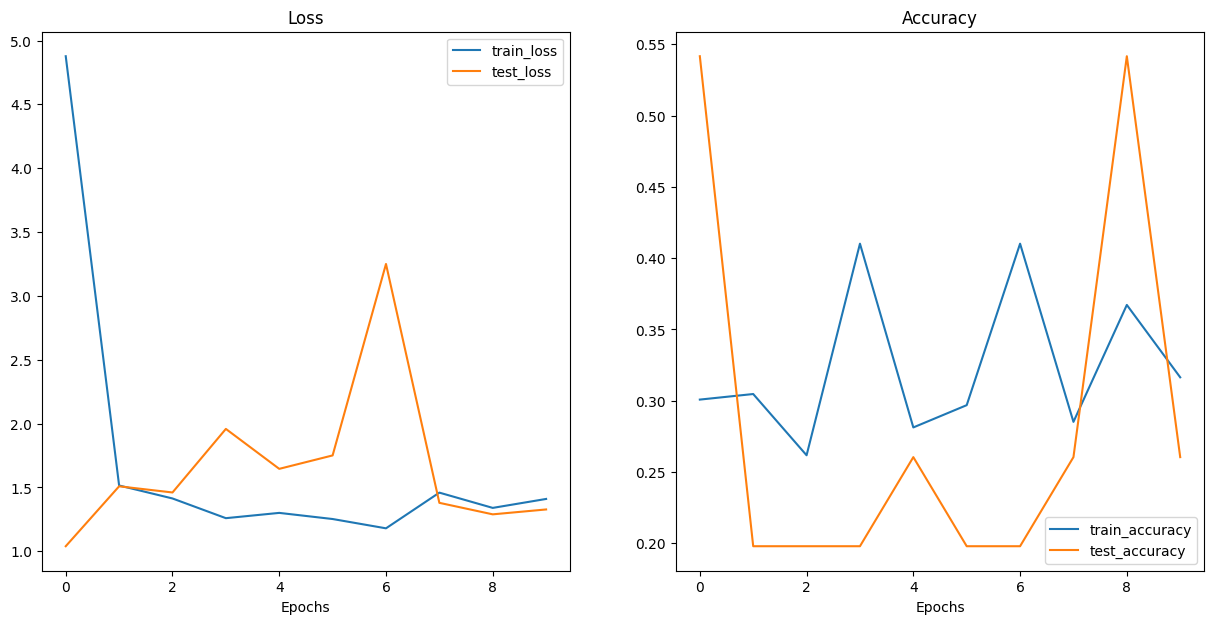

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

Hmm it looks like our model is underfitting and overfitting... I wonder what techniques we could use to take care of both at the same time?

See more here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

#10. Using a pretrained ViT from torchvision.models
Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

โดยทั่วไปใน Deep Learning หากคุณสามารถใช้โมเดลที่ฝึกมาจากชุดข้อมูลขนาดใหญ่กับปัญหาของคุณเองได้ นี่มักเป็นจุดเริ่มต้นที่ดี

หากสามารถหาโมเดลที่ฝึกมาแล้วและใช้การเรียนรู้ถ่ายโอน (transfer learning) ควรลองใช้ดู มักจะได้ผลลัพธ์ที่ดีแม้มีข้อมูลน้อย

##10.1 Why use a pretrained model?
* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

In [ ]:

# Cost of a TPUv3 for 30 days
cost = 30*24*8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost}USD")

In [ ]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.0+cu121
0.20.0+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 140MB/s] 


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

##10.3 Preparing data for the pretrained ViT model
When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

การเตรียมข้อมูลสำหรับโมเดล ViT ที่ผ่านการฝึกฝน

 การเตรียมข้อมูลสำหรับโมเดล ViT ที่ผ่านการฝึกมาแล้ว
เมื่อใช้โมเดลที่ฝึกมาแล้ว คุณควรตรวจสอบให้แน่ใจว่าข้อมูลของคุณมีรูปแบบเหมือนกับข้อมูลที่ใช้ฝึกโมเดลนั้น

เพราะอะไรเราถึงเลือกใช้ pretrained
สถาปัตยกรรม ViT (Vision Transformer) ออกแบบมาเพื่อทำงานกับข้อมูลขนาดใหญ่ เนื่องจากการเรียนรู้จากข้อมูลขนาดใหญ่นั้นช่วยให้โมเดลเข้าใจและเรียนรู้ลักษณะเชิงลึกของข้อมูลได้ดียิ่งขึ้น ส่งผลให้มีประสิทธิภาพที่ดีในการทำนาย

เนื่องจาก ViT ต้องการข้อมูลที่มากเพื่อลดปัญหา overfitting ซึ่งอาจเกิดขึ้นหากฝึกด้วยข้อมูลขนาดเล็ก ดังนั้น หากไม่มีข้อมูลขนาดใหญ่ การใช้ pretrained model แล้วทำ fine-tuning บนข้อมูลเฉพาะทางของคุณเป็นแนวทางที่เหมาะสมและมีประสิทธิภาพ

In [ ]:
# Get automtic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model                                                                                           test_dir=test_dir,)


#10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


##10.5 Plot the loss curves of our pretrained ViT feature extractor model

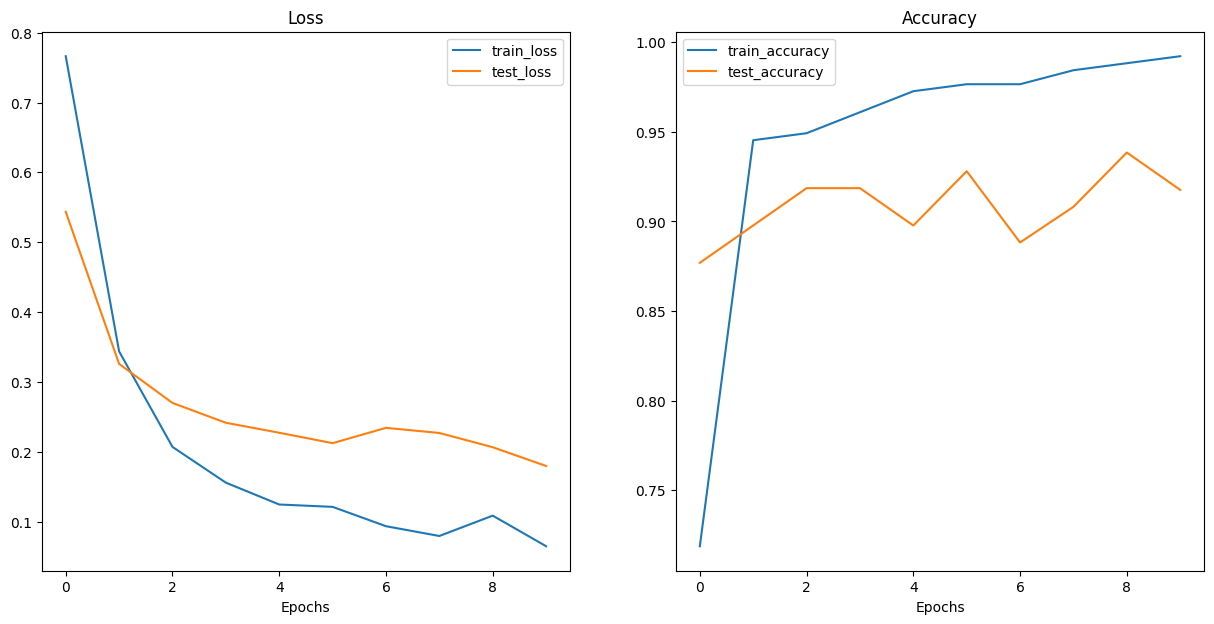

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

##10.6 Save our best performing ViT model
Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

ตอนนี้เรามีโมเดลที่ทำงานได้ดีแล้ว เราสามารถบันทึกโมเดลไปยังไฟล์และตรวจสอบขนาดของไฟล์ได้

เราต้องการตรวจสอบขนาดไฟล์เพราะหากต้องการนำโมเดลไปใช้งานบนเว็บไซต์หรือแอปพลิเคชันมือถือ อาจมีข้อจำกัดเกี่ยวกับขนาดของโมเดลที่สามารถใช้งานได้

เช่น โมเดลที่มีขนาดเล็กอาจจำเป็นต้องใช้เพราะข้อจำกัดด้านการคำนวณ

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


โมเดล ViT ที่เราฝึกไว้ล่วงหน้าให้ผลลัพธ์ที่ดีที่สุดในปัญหา FoodVision Mini ของเรา แต่ขนาดของโมเดลนั้นใหญ่กว่าที่สองที่ดีที่สุดของเราถึง ~11 เท่า

อาจจะทำให้ขนาดโมเดลใหญ่เกิดปัญหาตอนที่เราต้องการนำไปใช้งาน เช่น อาจจะยากในการนำไปใช้งาน (ไฟล์ใหญ่เกินไป) หรืออาจทำให้การทำนายช้ากว่าโมเดลที่เล็กกว่า

#11. Predicting on a custom image

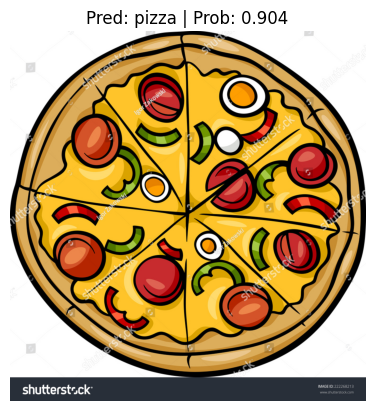

In [ ]:
# Download custom image
import requests
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://www.shutterstock.com/shutterstock/photos/222268213/display_1500/stock-vector-cartoon-vector-illustration-of-italian-pizza-food-object-222268213.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)